# Creating model regression

## Obtención y visualización de datos

#### Comenzaremos creando modelos de regresión lineal multivariable. Para ello, veremos que features son más influyentes para nuestra predicción, y posteriormente veremos si es o no necesario tratar previamente los datos para mejorar la predicción.

##### Importamos las librerías necesarias

In [11]:
import pandas as pd
import numpy as np

##### Importamos los datos post-procesados. Con ellos entrenaremos y testearemos nuestro modelo.

In [12]:
train_dataset = pd.read_csv('train_dataset.csv',sep=';')
test_dataset = pd.read_csv('test_dataset_17.csv',sep=';')

##### Analizamos la matríz del coeficiente de correlación de Pearson, entre las variables de entrada y las variables de salida. Donde podremos comprobar que los valores que las características que más inciden en el resultado final son: "Global_Radiation", "Diffuse_Radiation" y "Ultraviolet".

In [13]:
train_dataset[['Ambient_Temperature', 'Global_Radiation', 'Diffuse_Radiation',
              'Ultraviolet', 'Wind_Velocity', 'Wind_direction','A_Optimal_VDC', 
              'A_Optimal_CDC', 'A_Optimal_PDC']].corr(method='pearson')

,Ambient_Temperature,Global_Radiation,Diffuse_Radiation,Ultraviolet,Wind_Velocity,Wind_direction,A_Optimal_VDC,A_Optimal_CDC,A_Optimal_PDC
Ambient_Temperature,1.000000,0.435706,0.092518,0.437258,0.149270,-0.037590,-0.084023,0.189224,0.166931
Global_Radiation,0.435706,1.000000,0.378795,0.988810,0.352393,-0.104508,0.264275,0.833667,0.827551
Diffuse_Radiation,0.092518,0.378795,1.000000,0.400834,0.244072,-0.055271,0.286975,0.327219,0.333555
Ultraviolet,0.437258,0.988810,0.400834,1.000000,0.366322,-0.091197,0.252618,0.816207,0.808993
Wind_Velocity,0.149270,0.352393,0.244072,0.366322,1.000000,0.143714,0.219786,0.308331,0.315772
Wind_direction,-0.037590,-0.104508,-0.055271,-0.091197,0.143714,1.000000,-0.028437,-0.116317,-0.117228
A_Optimal_VDC,-0.084023,0.264275,0.286975,0.252618,0.219786,-0.028437,1.000000,0.311546,0.347299
A_Optimal_CDC,0.189224,0.833667,0.327219,0.816207,0.308331,-0.116317,0.311546,1.000000,0.997817
A_Optimal_PDC,0.166931,0.827551,0.333555,0.808993,0.315772,-0.117228,0.347299,0.997817,1.000000


##### Guardamos los campos que vamos a utilizar para la predicción.

Seleccionamos solo las variables que vamos autilizar para la predicción y testeo de los modelos. 

Inicialmente, trabajaremos con la predicción de los parámetros de tensión, corriente y potencia de la placa modelo A. Al final lo extenderemos a la placa modelo B, cuando hayaramos determinado el mejor modelo para cada variable. Haremos lo mismo para el archivo de los datos usados para el test final, aunque no los usemos todavía.

In [14]:
input_features = ['Global_Radiation', 'Diffuse_Radiation', 
                  'Ultraviolet']

output_features = ['A_Optimal_VDC', 'A_Optimal_CDC', 'A_Optimal_PDC']

In [111]:
# Datos de los años desde 2014 hasta 2017
X_train_dataset = train_dataset[input_features]

y_train_dataset = train_dataset[output_features]

# Datos de la última semana de 2017
X_test_dataset = test_dataset[input_features]

y_test_dataset = test_dataset[output_features]

##### Graficamos las variables linealmente para conocer su relación de forma visual.

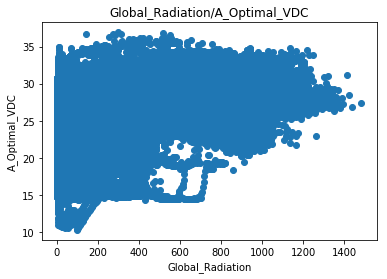

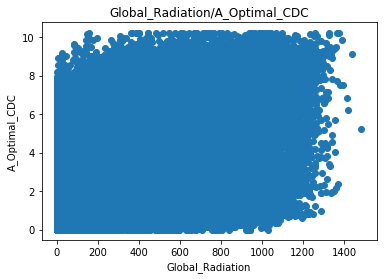

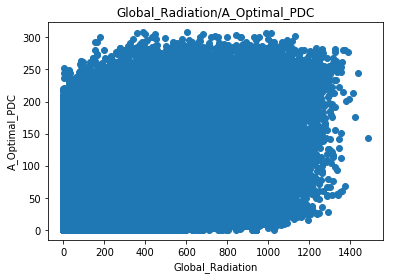

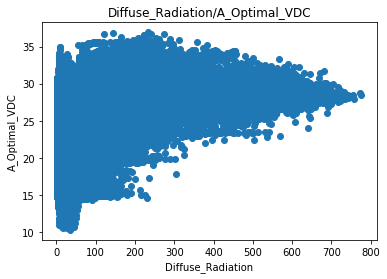

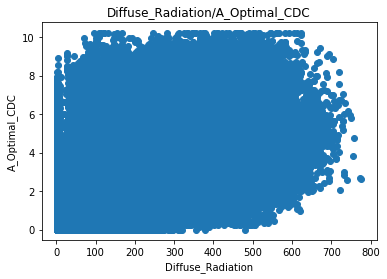

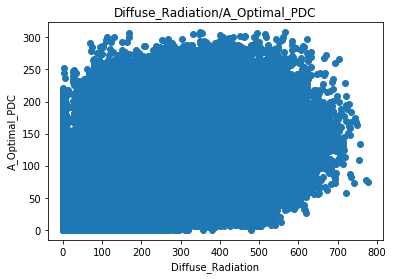

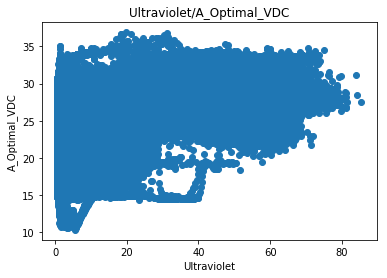

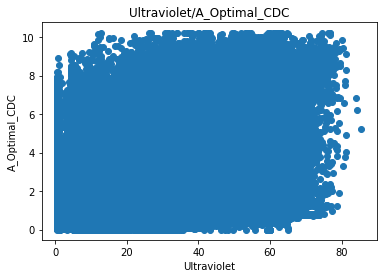

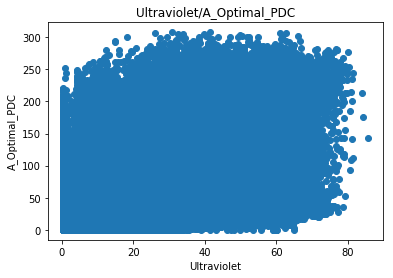

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

# Recorremos todos los features de entreda y los graficamos con los features de salida, uno por uno.
for nam_col in X_train_dataset.columns:
    for nam_col2 in y_train_dataset.columns:
            plt.scatter(X_train_dataset[nam_col], y_train_dataset[nam_col2])
            plt.title(nam_col+'/'+nam_col2)
            plt.xlabel(nam_col)
            plt.ylabel(nam_col2)
            plt.show()

## Creación de modelo de regresión lineal

### 1º- Modelo con datos en bruto.

Creamos un modelo de regresión lineal para cada una de las variables de salida. Luego testearemos el modelo final. No aplicaremos fase de validación por ser una regresión simple.

##### Importamos el modelo de regresión de SKlearn.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [128]:
# Creating model
reg_VDC = LinearRegression()

#Training model
reg_VDC.fit(X_train_dataset, y_train_dataset[['A_Optimal_VDC']])
result_VDC = pd.DataFrame(reg_VDC.predict(X_test_dataset)).rename(columns = {0:'Predict_VDC'})

# Adding result in the same dataframe and difference between both
result_VDC['Real_VDC'] = y_test_dataset['A_Optimal_VDC']
result_VDC['Residual_VDC'] = result_VDC['Predict_VDC']-result_VDC['Real_VDC']
result_VDC['Resid_VDC_%'] = np.abs(result_VDC['Residual_VDC']/result_VDC['Real_VDC']*100)

result_VDC.head()

,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,26.378758,19.650,6.728758,34.243043
1,26.381694,27.625,-1.243306,4.500654
2,27.216426,29.900,-2.683574,8.975165
3,27.288532,29.250,-1.961468,6.705874
4,27.308776,29.800,-2.491224,8.359813


##### Métricas del modelo: MAE, MAPE y R2

In [115]:
print('MAE: ', np.mean(np.abs(result_VDC['Residual_VDC'])))
print('MAPE: ', np.mean(result_VDC['Resid_VDC_%']))
print('R^2: ', r2_score(result_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC']))

MAE:  1.7535237391137646
MAPE:  26.11130337976907
R^2:  -8.535369303049062


### Modelo para el parámetro de corriente en corriente continua (CDC).

In [131]:
# Creating model
reg_CDC = LinearRegression()

#Training model
reg_CDC.fit(X_train_dataset, y_train_dataset[['A_Optimal_CDC']])
result_CDC = pd.DataFrame(reg_CDC.predict(X_test_dataset)).rename(columns = {0:'Predict_CDC'})

# Adding result in the same dataframe and difference between both
result_CDC['Real_CDC'] = y_test_dataset['A_Optimal_CDC']
result_CDC['Residual_CDC'] = result_CDC['Predict_CDC']-result_CDC['Real_CDC']
result_CDC['Resid_CDC_%'] = np.abs(result_CDC['Residual_CDC']/result_CDC['Real_CDC']*100)

result_CDC.head()

,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,0.596451,0.3975,0.198951,50.050462
1,0.612633,0.5075,0.105133,20.715833
2,2.214201,3.9650,-1.750799,44.156345
3,2.326889,4.1300,-1.803111,43.658872
4,2.363566,4.0500,-1.686434,41.640351


##### Métricas del modelo: MAE, MAPE y R2

In [117]:
print('MAE: ', np.mean(np.abs(result_CDC['Residual_CDC'])))
print('MAPE: ', np.mean(result_CDC['Resid_CDC_%']))
print('R^2: ', r2_score(result_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC']))

MAE:  0.9049927117714806
MAPE:  1.0185317610874642
R^2:  -0.23930247313484432


### Modelo para el parámetro de potencia en corriente continua (PDC).

In [133]:
# Creating model
reg_PDC = LinearRegression()

#Training model
reg_PDC.fit(X_train_dataset, y_train_dataset[['A_Optimal_PDC']])
result_PDC = pd.DataFrame(reg_PDC.predict(X_test_dataset)).rename(columns = {0:'Predict_PDC'})

# Adding result in the same dataframe and difference between both
result_PDC['Real_PDC'] = y_test_dataset['A_Optimal_PDC']
result_PDC['Residual_PDC'] = result_PDC['Predict_PDC']-result_PDC['Real_PDC']
result_PDC['Resid_PDC_%'] = np.abs(result_PDC['Residual_PDC']/result_PDC['Real_PDC']*100)

result_PDC.head()

,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,17.318676,7.810875,9.507801,121.725166
1,17.759358,9.947000,7.812358,78.539844
2,63.212482,118.553500,-55.341018,46.680206
3,66.449445,120.802500,-54.353055,44.993320
4,67.485013,120.690000,-53.204987,44.084006


##### Métricas del modelo: MAE, MAPE y R2

In [119]:
print('MAE: ', np.mean(np.abs(result_PDC['Residual_PDC'])))
print('MAPE: ', np.mean(result_PDC['Resid_PDC_%']))
print('R^2: ', r2_score(result_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC']))

MAE:  26.857066545097886
MAPE:  50.68798478104361
R^2:  -0.34135536277777456


### 2º- Datos normalizados

Debido a que las métricas nos dan valores muy malos, vamos a normalizar los datos de entrada para intentar mejorar los resultados.

In [19]:
from sklearn.preprocessing import MinMaxScaler

##### Normalizamos los valores de entrada de los dataset de train y test.

In [20]:
scaler_train = MinMaxScaler()
X_train_sc = scaler_train.fit_transform(X_train_dataset)
X_train_sc = pd.DataFrame(X_train_sc, columns=['Global_Radiation', 'Diffuse_Radiation','Ultraviolet'])

scaler_test = MinMaxScaler()
X_test_sc = scaler_test.fit_transform(X_test_dataset)
X_test_sc = pd.DataFrame(X_test_sc, columns=['Global_Radiation', 'Diffuse_Radiation', 'Ultraviolet'])

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [151]:
# Creating model
reg_VDC = LinearRegression()

#Training model
reg_VDC.fit(X_train_sc, y_train_dataset[['A_Optimal_VDC']])
result_VDC = pd.DataFrame(reg_VDC.predict(X_test_sc)).rename(columns = {0:'Predict_VDC'})

# Adding result in the same dataframe and difference between both
resultN_VDC['Real_VDC'] = y_test_dataset['A_Optimal_VDC']
resultN_VDC['Residual_VDC'] = resultN_VDC['Predict_VDC']-resultN_VDC['Real_VDC']
resultN_VDC['Resid_VDC_%'] = np.abs(resultN_VDC['Residual_VDC']/resultN_VDC['Real_VDC']*100)

resultN_VDC.head()

,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,26.444353,19.650,6.794353,34.576861
1,26.441088,27.625,-1.183912,4.285656
2,27.621811,29.900,-2.278189,7.619362
3,27.739872,29.250,-1.510128,5.162831
4,27.767171,29.800,-2.032829,6.821573


##### Métricas del modelo: MAE, MAPE y R2

In [125]:
print('MAE: ', np.mean(np.abs(resultN_VDC['Residual_VDC'])))
print('MAPE: ', np.mean(resultN_VDC['Resid_VDC_%']))
print('R^2: ', r2_score(resultN_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC']))

MAE:  1.5642952127539422
MAPE:  26.436151234216986
R^2:  -2.4105190822354787


### Modelo para el parámetro de corriente en corriente continua (CDC).

In [138]:
# Creating model
reg_CDC = LinearRegression()

#Training model
reg_CDC.fit(X_train_sc, y_train_dataset[['A_Optimal_CDC']])
resultN_CDC = pd.DataFrame(reg_CDC.predict(X_test_sc)).rename(columns = {0:'Predict_CDC'})

# Adding result in the same dataframe and difference between both
resultN_CDC['Real_CDC'] = y_test_dataset['A_Optimal_CDC']
resultN_CDC['Residual_CDC'] = resultN_CDC['Predict_CDC']-resultN_CDC['Real_CDC']
resultN_CDC['Resid_CDC_%'] = np.abs(resultN_CDC['Residual_CDC']/resultN_CDC['Real_CDC']*100)

resultN_CDC.head()

,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,0.655120,0.3975,0.257620,64.810071
1,0.679351,0.5075,0.171851,33.862257
2,3.377540,3.9650,-0.587460,14.816136
3,3.573021,4.1300,-0.556979,13.486173
4,3.632921,4.0500,-0.417079,10.298243


##### Métricas del modelo: MAE, MAPE y R2

In [139]:
print('MAE: ', np.mean(np.abs(resultN_CDC['Residual_CDC'])))
print('MAPE: ', np.mean(resultN_CDC['Resid_CDC_%']))
print('R^2: ', r2_score(resultN_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC']))

MAE:  0.838473421922051
MAPE:  128.93638629633503
R^2:  0.6448075446978627


### Modelo para el parámetro de potencia en corriente continua (PDC).

In [140]:
# Creating model
reg_PDC = LinearRegression()

#Training model
reg_PDC.fit(X_train_sc, y_train_dataset[['A_Optimal_PDC']])
resultN_PDC = pd.DataFrame(reg_PDC.predict(X_test_sc)).rename(columns = {0:'Predict_PDC'})

# Adding result in the same dataframe and difference between both
resultN_PDC['Real_PDC'] = y_test_dataset['A_Optimal_PDC']
resultN_PDC['Residual_PDC'] = resultN_PDC['Predict_PDC']-resultN_PDC['Real_PDC']
resultN_PDC['Resid_PDC_%'] = np.abs(resultN_PDC['Residual_PDC']/resultN_PDC['Real_PDC']*100)

resultN_PDC.head()

,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,18.962320,7.810875,11.151445,142.768197
1,19.591055,9.947000,9.644055,96.954411
2,95.052479,118.553500,-23.501021,19.823135
3,100.619632,120.802500,-20.182868,16.707327
4,102.277498,120.690000,-18.412502,15.256030


##### Métricas del modelo: MAE, MAPE y R2

In [141]:
print('MAE: ', np.mean(np.abs(resultN_PDC['Residual_PDC'])))
print('MAPE: ', np.mean(resultN_PDC['Resid_PDC_%']))
print('R^2: ', r2_score(resultN_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC']))

MAE:  24.328457350540855
MAPE:  139.41387139599414
R^2:  0.6221774360088022


### Conclusiónes sobre el modelo de regresión lineal

Como se puede observar, los datos mejoran considerablemente cuando se aplica normalización de los parámetros de entrada, sobretodo para las variables CDC y PDC.

La variable VDC, no posee ninguna relación lineal con el resto de valores de entrada, algo que se puede ver en la matriz de coeficientes de correlación de Pearson. Por lo tanto, dicha variable no se puede predecir mediante un modelo de regresión lineal. Probaremos si somos capaces de predecirla mediante otro modelo.

## Creación de modelo Arbol de decisión.

### Importamos las librerías necesarias para la creación del modelo

In [16]:
from sklearn.tree import DecisionTreeRegressor

#### Recuperamos los datos para evitar que hayan sido modificados en el proceso

In [17]:
# Datos de los años desde 2014 hasta 2017
X_train_dataset = train_dataset[input_features]

y_train_dataset = train_dataset[output_features]

# Datos de la última semana de 2017
X_test_dataset = test_dataset[input_features]

y_test_dataset = test_dataset[output_features]

### Normalización de los datos

Debido a los resultados obtenidos en las pruebas anteriores, se procederá a trabajar directamente con los datos normalizados, ya que los resultados mejoran considerablemente.

In [21]:
scaler_train = MinMaxScaler()
X_train_sc = scaler_train.fit_transform(X_train_dataset)
X_train_sc = pd.DataFrame(X_train_sc, columns=['Global_Radiation', 'Diffuse_Radiation','Ultraviolet'])

scaler_test = MinMaxScaler()
X_test_sc = scaler_test.fit_transform(X_test_dataset)
X_test_sc = pd.DataFrame(X_test_sc, columns=['Global_Radiation', 'Diffuse_Radiation', 'Ultraviolet'])

### 1º- Creación de modelo de profundidad 3

Inicialmente, probaremos con el modelo de 3 capas para ver si los resultados mejoran frente al modelo de regresión lineal. Luego, intentaremos regularizar el modelo, buscando cuales son los parámetros más óptimos para el mismo.

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [22]:
# Creating model
regd_VDC = DecisionTreeRegressor(max_depth=3)

#Training model
regd_VDC.fit(X_train_sc, y_train_dataset[['A_Optimal_VDC']])
resultD_VDC = pd.DataFrame(regd_VDC.predict(X_test_sc)).rename(columns = {0:'Predict_VDC'})

# Adding result in the same dataframe and difference between both
resultD_VDC['Real_VDC'] = y_test_dataset['A_Optimal_VDC']
resultD_VDC['Residual_VDC'] = resultD_VDC['Predict_VDC']-resultD_VDC['Real_VDC']
resultD_VDC['Resid_VDC_%'] = np.abs(resultD_VDC['Residual_VDC']/resultD_VDC['Real_VDC']*100)

resultD_VDC.head()

,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,24.821733,19.650,5.171733,26.319252
1,24.821733,27.625,-2.803267,10.147573
2,28.334643,29.900,-1.565357,5.235308
3,28.334643,29.250,-0.915357,3.129426
4,28.334643,29.800,-1.465357,4.917306


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [24]:
print('MAE: ', np.mean(np.abs(resultD_VDC['Residual_VDC'])))
print('MAPE: ', np.mean(resultD_VDC['Resid_VDC_%']))
print('R^2: ', r2_score(resultD_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC']))
print('Correlation: ', np.corrcoef(resultD_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC'])[0][1])

MAE:  1.393118120482622
MAPE:  5.077882696639895


NameError: name 'r2_score' is not defined

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [160]:
# Creating model
regd_CDC = DecisionTreeRegressor(max_depth=3)

#Training model
regd_CDC.fit(X_train_sc, y_train_dataset[['A_Optimal_CDC']])
resultD_CDC = pd.DataFrame(regd_CDC.predict(X_test_sc)).rename(columns = {0:'Predict_CDC'})

# Adding result in the same dataframe and difference between both
resultD_CDC['Real_CDC'] = y_test_dataset['A_Optimal_CDC']
resultD_CDC['Residual_CDC'] = resultD_CDC['Predict_CDC']-resultD_CDC['Real_CDC']
resultD_CDC['Resid_CDC_%'] = np.abs(resultD_CDC['Residual_CDC']/resultD_CDC['Real_CDC']*100)

resultD_CDC.head()

,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,0.423392,0.3975,0.025892,6.513613
1,0.423392,0.5075,-0.084108,16.573081
2,3.903186,3.9650,-0.061814,1.558998
3,3.903186,4.1300,-0.226814,5.491871
4,3.903186,4.0500,-0.146814,3.625044


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [161]:
print('MAE: ', np.mean(np.abs(resultD_CDC['Residual_CDC'])))
print('MAPE: ', np.mean(resultD_CDC['Resid_CDC_%']))
print('R^2: ', r2_score(resultD_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC']))
print('Correlation: ', np.corrcoef(resultD_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC'])[0][1])

MAE:  1.0086183637096693
MAPE:  140.14528229896038
R^2:  0.556970988192642
Correlation:  0.8489632623612186


### Modelo para el parámetro de potencia en corriente continua (PDC).

In [168]:
# Creating model
regd_PDC = DecisionTreeRegressor(max_depth=3)

#Training model
regd_PDC.fit(X_train_sc, y_train_dataset[['A_Optimal_PDC']])
resultD_PDC = pd.DataFrame(regd_PDC.predict(X_test_sc)).rename(columns = {0:'Predict_PDC'})

# Adding result in the same dataframe and difference between both
resultD_PDC['Real_PDC'] = y_test_dataset['A_Optimal_PDC']
resultD_PDC['Residual_PDC'] = resultD_PDC['Predict_PDC']-resultD_PDC['Real_PDC']
resultD_PDC['Resid_PDC_%'] = np.abs(resultD_PDC['Residual_PDC']/resultD_PDC['Real_PDC']*100)

resultD_PDC.head()

,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,12.656081,7.810875,4.845206,62.031543
1,12.656081,9.947000,2.709081,27.235160
2,110.070378,118.553500,-8.483122,7.155522
3,110.070378,120.802500,-10.732122,8.884023
4,110.070378,120.690000,-10.619622,8.799090


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [169]:
print('MAE: ', np.mean(np.abs(resultD_PDC['Residual_PDC'])))
print('MAPE: ', np.mean(resultD_PDC['Resid_PDC_%']))
print('R^2: ', r2_score(resultD_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC']))
print('Correlation: ', np.corrcoef(resultD_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC'])[0][1])

MAE:  27.294648967486623
MAPE:  131.6648805211968
R^2:  0.5881220508549543
Correlation:  0.8495244517063844


### 2º- Optimización de hiperparámetros.

Tras probar el modelo básico de 3 capas, buscamos mejorar el modelo optimizando los hiperparametros.

##### Importamos librerías

In [38]:
from sklearn.model_selection import GridSearchCV

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [80]:
# Creating model by GridSeachCV

regDG_VDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(1, 30),
                                      "min_samples_split": np.arange(25, 35),
                                      "min_samples_leaf": np.arange(25, 35)
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

#Training model
regDG_VDC.fit(X_train_sc, y_train_dataset[['A_Optimal_VDC']])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'min_samples_split': array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34]), 'min_samples_leaf': array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
regDG_VDC.best_params_

In [ ]:
regDG_VDC.best_score_

In [ ]:
resultDG_VDC = pd.DataFrame(regDG_VDC.best_estimator_.predict(X_test_sc)).rename(columns = {0:'Predict_VDC'})

resultDG_VDC['Real_VDC'] = y_test_dataset['A_Optimal_VDC']
resultDG_VDC['Residual_VDC'] = resultDG_VDC['Predict_VDC']-resultDG_VDC['Real_VDC']
resultDG_VDC['Resid_VDC_%'] = np.abs(resultDG_VDC['Residual_VDC']/resultDG_VDC['Real_VDC']*100)

print(resultDG_VDC.head())
print('error absoluto medio: ', mean_absolute_error(resultDG_VDC['Predict_VDC'],resultDG_VDC['Real_VDC']))
print('parametro R2: ', r2_score(resultDG_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC']))
print('Correlation: ', np.corrcoef(resultDG_VDC['Predict_VDC'],y_test_dataset['A_Optimal_VDC'])[0][1])

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [85]:
# Creating model by GridSeachCV

regDG_CDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(2,8),
                                      "min_samples_split": [10,30,50,100],
                                      "min_samples_leaf": [10,30,50,100]
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

#Training model
regDG_CDC.fit(X_train_sc, y_train_dataset[['A_Optimal_CDC']])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7]), 'min_samples_split': [10, 30, 50, 100], 'min_samples_leaf': [10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [86]:
regDG_CDC.best_params_

{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 30}

In [87]:
regDG_CDC.best_score_

-1.0183205224030112

In [88]:
resultDG_CDC = pd.DataFrame(regDG_CDC.best_estimator_.predict(X_test_sc)).rename(columns = {0:'Predict_CDC'})

resultDG_CDC['Real_CDC'] = y_test_dataset['A_Optimal_CDC']
resultDG_CDC['Residual_CDC'] = resultDG_CDC['Predict_CDC']-resultDG_CDC['Real_CDC']
resultDG_CDC['Resid_CDC_%'] = np.abs(resultDG_CDC['Residual_CDC']/resultDG_CDC['Real_CDC']*100)

print(resultDG_CDC.head())
print(y_test_dataset['A_Optimal_CDC'].head())
print('error absoluto medio: ', mean_absolute_error(resultDG_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC']))
print('parametro R2: ', r2_score(resultDG_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC']))
print('Correlation: ', np.corrcoef(resultDG_CDC['Predict_CDC'],y_test_dataset['A_Optimal_CDC'])[0][1])

   Predict_CDC  Real_CDC  Residual_CDC  Resid_CDC_%
0     0.375587    0.3975     -0.021913     5.512583
1     0.375587    0.5075     -0.131913    25.992614
2     4.034013    3.9650      0.069013     1.740567
3     4.034013    4.1300     -0.095987     2.324129
4     4.034013    4.0500     -0.015987     0.394729
0    0.3975
1    0.5075
2    3.9650
3    4.1300
4    4.0500
Name: A_Optimal_CDC, dtype: float64
error absoluto medio:  1.312513051105873
parametro R2:  0.17948645039976052
Correlation:  0.7427026595518234


### Modelo para el parámetro de potencia en corriente continua (PDC).

In [89]:
# Creating model by GridSeachCV

regDG_PDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(2,8),
                                      "min_samples_split": [10,30,50,100],
                                      "min_samples_leaf": [10,30,50,100]
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

#Training model
regDG_PDC.fit(X_train_sc, y_train_dataset[['A_Optimal_PDC']])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7]), 'min_samples_split': [10, 30, 50, 100], 'min_samples_leaf': [10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [90]:
regDG_PDC.best_params_

{'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 30}

In [91]:
regDG_PDC.best_score_

-28.362774182284863

In [92]:
resultDG_PDC = pd.DataFrame(regDG_CDC.best_estimator_.predict(X_test_sc)).rename(columns = {0:'Predict_PDC'})

resultDG_PDC['Real_PDC'] = y_test_dataset['A_Optimal_PDC']
resultDG_PDC['Residual_PDC'] = resultDG_PDC['Predict_PDC']-resultDG_PDC['Real_PDC']
resultDG_PDC['Resid_PDC_%'] = np.abs(resultDG_PDC['Residual_PDC']/resultDG_PDC['Real_PDC']*100)

print(resultDG_PDC.head())
print(y_test_dataset['A_Optimal_PDC'].head())
print('error absoluto medio: ', mean_absolute_error(resultDG_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC']))
print('parametro R2: ', r2_score(resultDG_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC']))
print('Correlation: ', np.corrcoef(resultDG_PDC['Predict_PDC'],y_test_dataset['A_Optimal_PDC'])[0][1])

   Predict_PDC    Real_PDC  Residual_PDC  Resid_PDC_%
0     0.375587    7.810875     -7.435288    95.191480
1     0.375587    9.947000     -9.571413    96.224113
2     4.034013  118.553500   -114.519487    96.597305
3     4.034013  120.802500   -116.768487    96.660654
4     4.034013  120.690000   -116.655987    96.657541
0      7.810875
1      9.947000
2    118.553500
3    120.802500
4    120.690000
Name: A_Optimal_PDC, dtype: float64
error absoluto medio:  61.68454921678374
parametro R2:  -2045.8060194546633
Correlation:  0.7480581541055648
